In [ ]:
# Sai Triveni Kottapalli
# ID - C00313481  

# Decision Trees and Random Forests

In this section, we will explore a powerful algorithm known as *random forests*, which is a type of nonparametric algorithm. Random forests are categorized as an *ensemble* method, meaning they rely on combining the results from a set of simpler estimators. Interestingly, in ensemble methods, the overall outcome can surpass that of the individual components: the predictive accuracy of a majority vote among several estimators can be better than that of any single estimator involved in the voting.

To begin, let’s start with the standard imports:

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import warnings
warnings.filterwarnings("ignore")

## Motivating Random Forests: Decision Trees

Random forests are an example of an ensemble learning method that is based on decision trees. Therefore, we will begin by discussing decision trees themselves.

Decision trees are intuitive tools for classifying or labeling objects. They work by asking a series of questions that help narrow down the classification. For instance, if you wanted to create a decision tree to classify animals you encounter during a hike, you could construct one similar to the example shown in the following figure.

Binary splitting makes decision trees highly efficient. In a well-structured tree, each question reduces options by about half, quickly narrowing down possibilities even with many classes. 

The challenge is deciding which questions to ask. In machine learning decision trees, these questions typically involve axis-aligned splits, where each node divides the data into two groups based on a cutoff value for a feature.

Let's look at an example to illustrate this.


### Creating a Decision Tree

Consider the following two-dimensional data, which has one of four class labels:

In [3]:
# changed no. of samples to 500, cluster_std = 1.5
# plotting scatter plot more efficiently by adding labels and changing colors

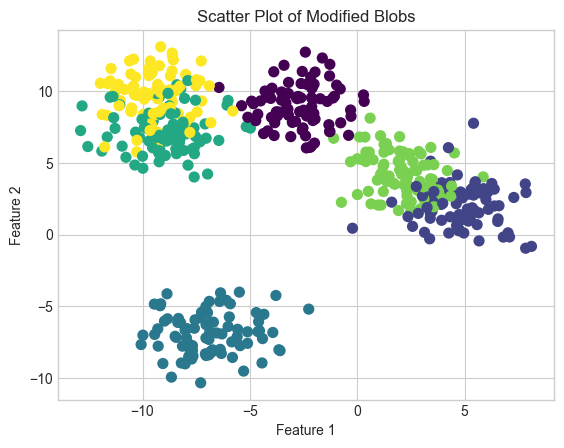

In [4]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=500, centers=6, random_state=42, cluster_std=1.5)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='viridis')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Modified Blobs")
plt.show()

A simple decision tree constructed using this data will iteratively divide the dataset along different axes based on a quantitative criterion. At each level of the tree, it will assign a label to the new region according to the majority vote of the points within that region. 

The figure below visualizes the first four levels of a decision tree classifier created from this data.

This process of fitting a decision tree to our data can be done in Scikit-Learn with the ``DecisionTreeClassifier`` estimator:

In [5]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Let's write a utility function to help us visualize the output of the classifier:

In [6]:
# changed s = 50 from s = 30
# changed num = 300 from num = 200
# plotting scatter plot more efficiently by adding labels and changing colors

In [7]:
def visualize_classifier(model, X, y, ax=None, cmap='viridis'):
    ax = ax or plt.gca()
    
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap=cmap, 
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('on')  
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=300),  
                         np.linspace(*ylim, num=300))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, zorder=1)

    ax.set(xlim=xlim, ylim=ylim)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Decision Boundary Visualization")
    plt.show()

Now we can examine what the decision tree classification looks like (see the following figure):

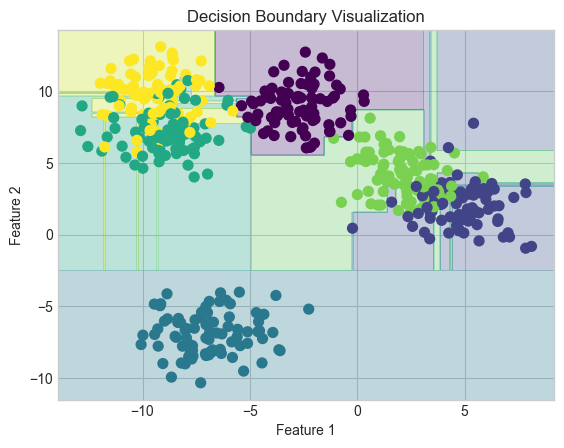

In [8]:
visualize_classifier(DecisionTreeClassifier(), X, y)

In [9]:
import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(IntSlider(value=5, description='depth', max=5, min=1), Output()), _dom_classes=('widget-…

### Decision Trees and Overfitting

Overfitting is a common issue with decision trees. It occurs easily when the tree is expanded too much, causing it to capture specific details of the training data instead of representing the general characteristics of the underlying distributions. Another way to illustrate this overfitting is by examining models trained on different subsets of the data. For instance, we can train two distinct trees, each using half of the original dataset.

It is evident that in certain areas, the two trees yield consistent results (for example, in the four corners), while in other regions, they produce significantly different classifications (such as between any two clusters). The main takeaway is that these inconsistencies typically arise in areas where the classification is less certain. Therefore, by leveraging information from both trees, we may achieve a more accurate result!

In [10]:
# helpers_05_08 is found in the online appendix
import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(IntSlider(value=0, description='random_state'), Output()), _dom_classes=('widget-interac…

## Ensembles of Estimators: Random Forests

The idea that multiple overfitting estimators can be combined to reduce overfitting is the foundation of an ensemble method called *bagging*. 

Bagging uses a collection of parallel estimators, each potentially overfitting the data, and averages their results to improve classification accuracy. An ensemble of randomized decision trees is known as a *random forest*.

It can be implemented this bagging classification manually using Scikit-Learn's `BaggingClassifier` meta-estimator, as shown in the following figure:

In [11]:
# changed n_estimators=200, max_samples=0.6
# plotting scatter plot more efficiently by adding labels and changing colors

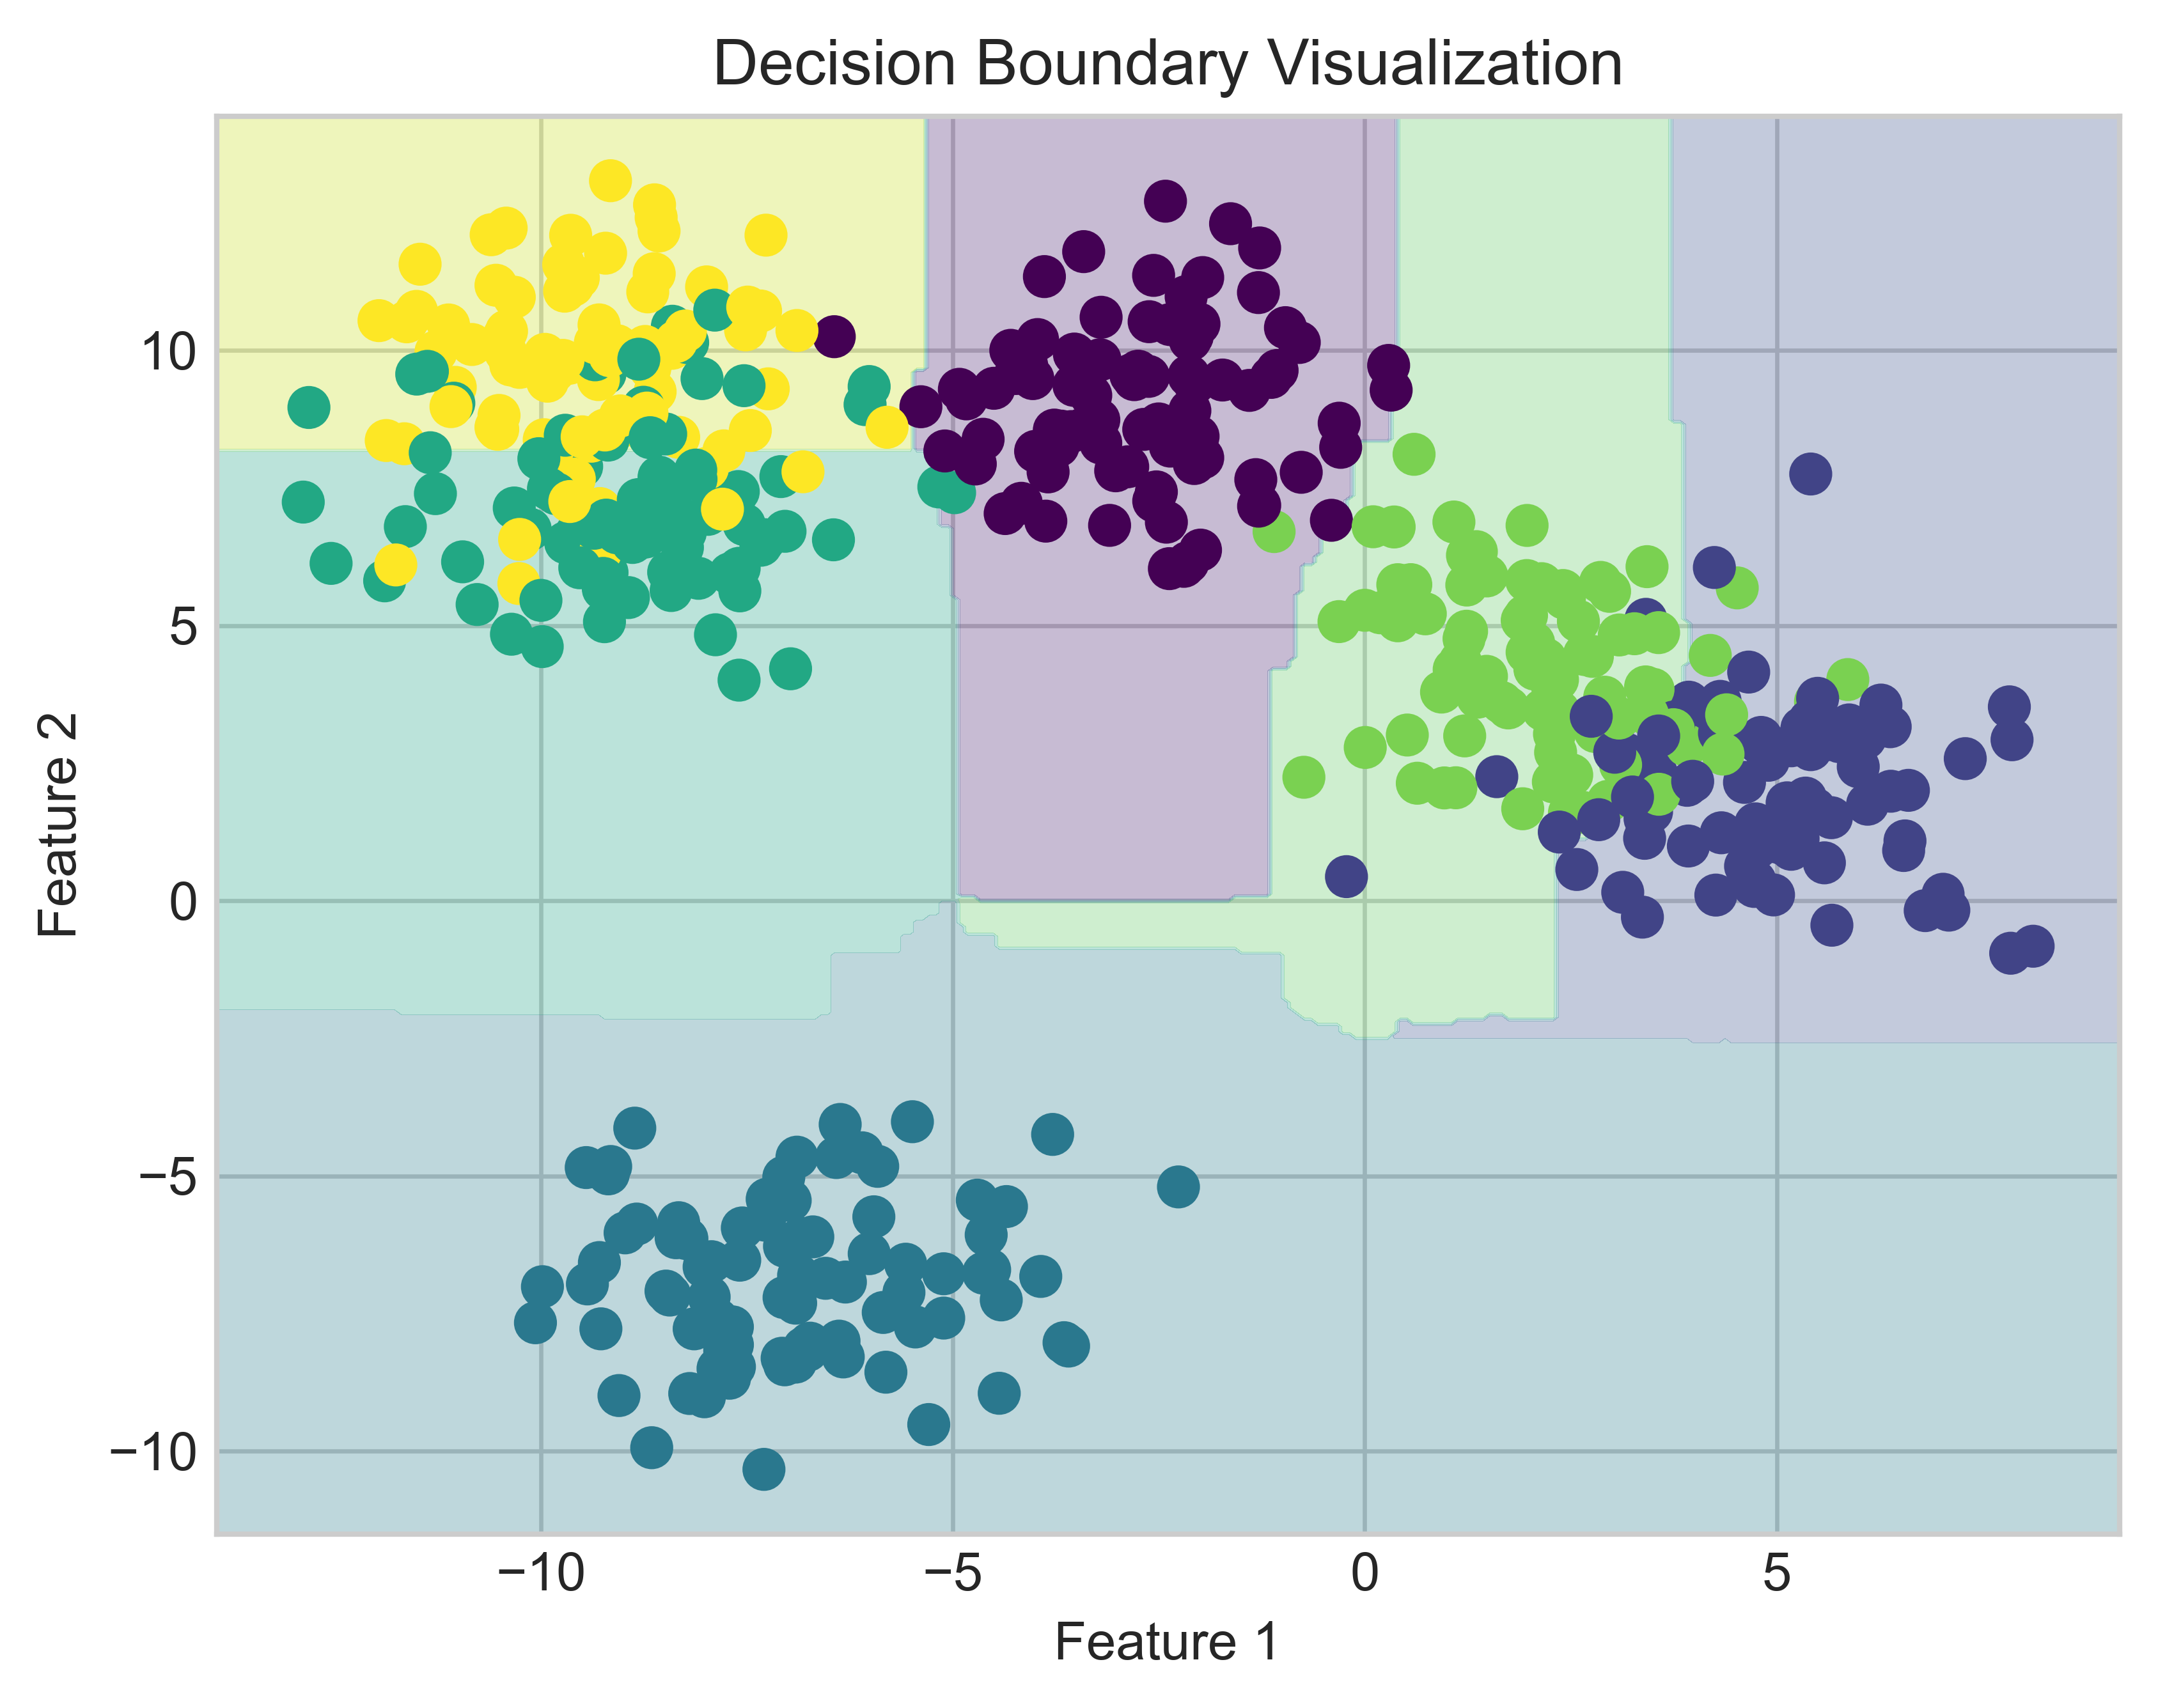

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier(max_depth=4, random_state=42)
bag = BaggingClassifier(tree, n_estimators=200, max_samples=0.6, random_state=42)
bag.fit(X, y)
visualize_classifier(bag, X, y)

In this example, we randomize the data by fitting each estimator with a random 80% subset of the training points. Decision trees are effectively randomized by introducing stochasticity in how splits are chosen, allowing all data to contribute to the fit while maintaining the desired randomness. For instance, when choosing a split feature, a randomized tree may select from several top features.

In Scikit-Learn, the `RandomForestClassifier` implements this optimized ensemble of randomized decision trees, automatically handling the randomization. You only need to select the number of estimators, and it will quickly fit the ensemble—potentially in parallel.

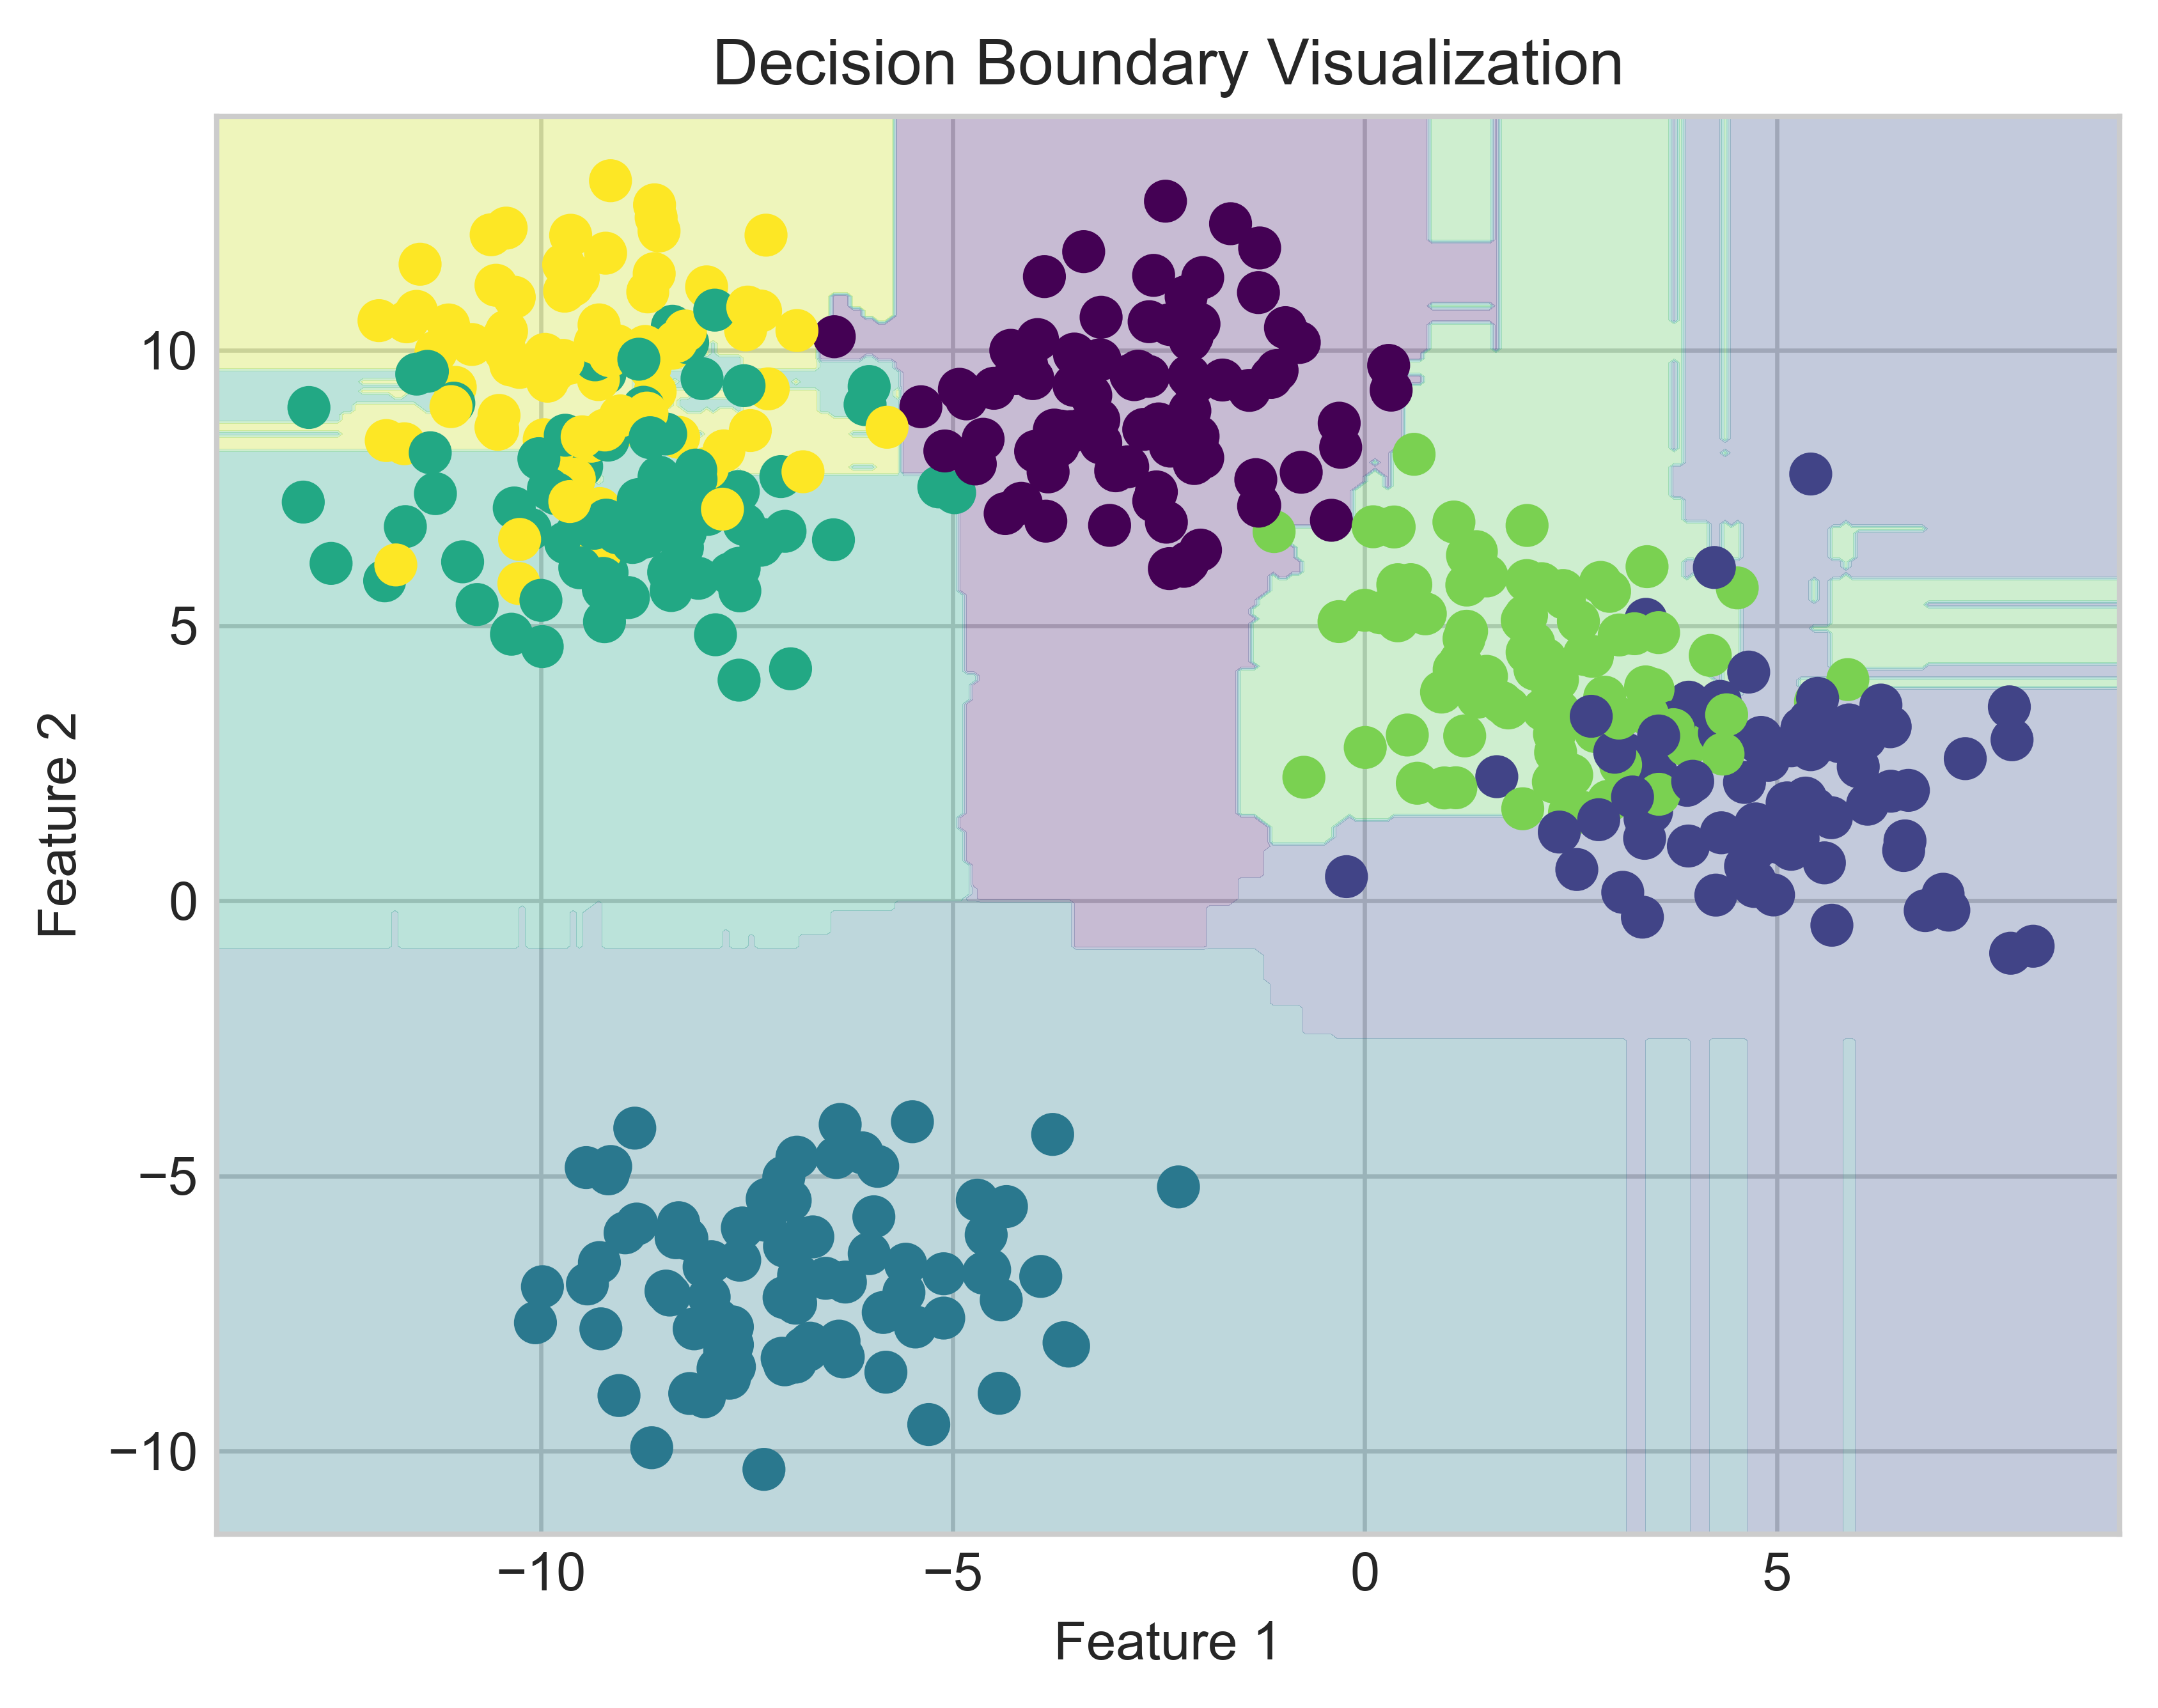

In [13]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
visualize_classifier(model, X, y);

## Random Forest Regression

In the previous section, we explored random forests in the context of classification. However, random forests can also be applied to regression tasks, which involve predicting continuous rather than categorical variables. To implement this, we use the `RandomForestRegressor`, and its syntax is very similar to what we discussed earlier.

Let’s consider some data that is generated from a combination of fast and slow oscillations:


In [14]:
# plotting model more efficiently

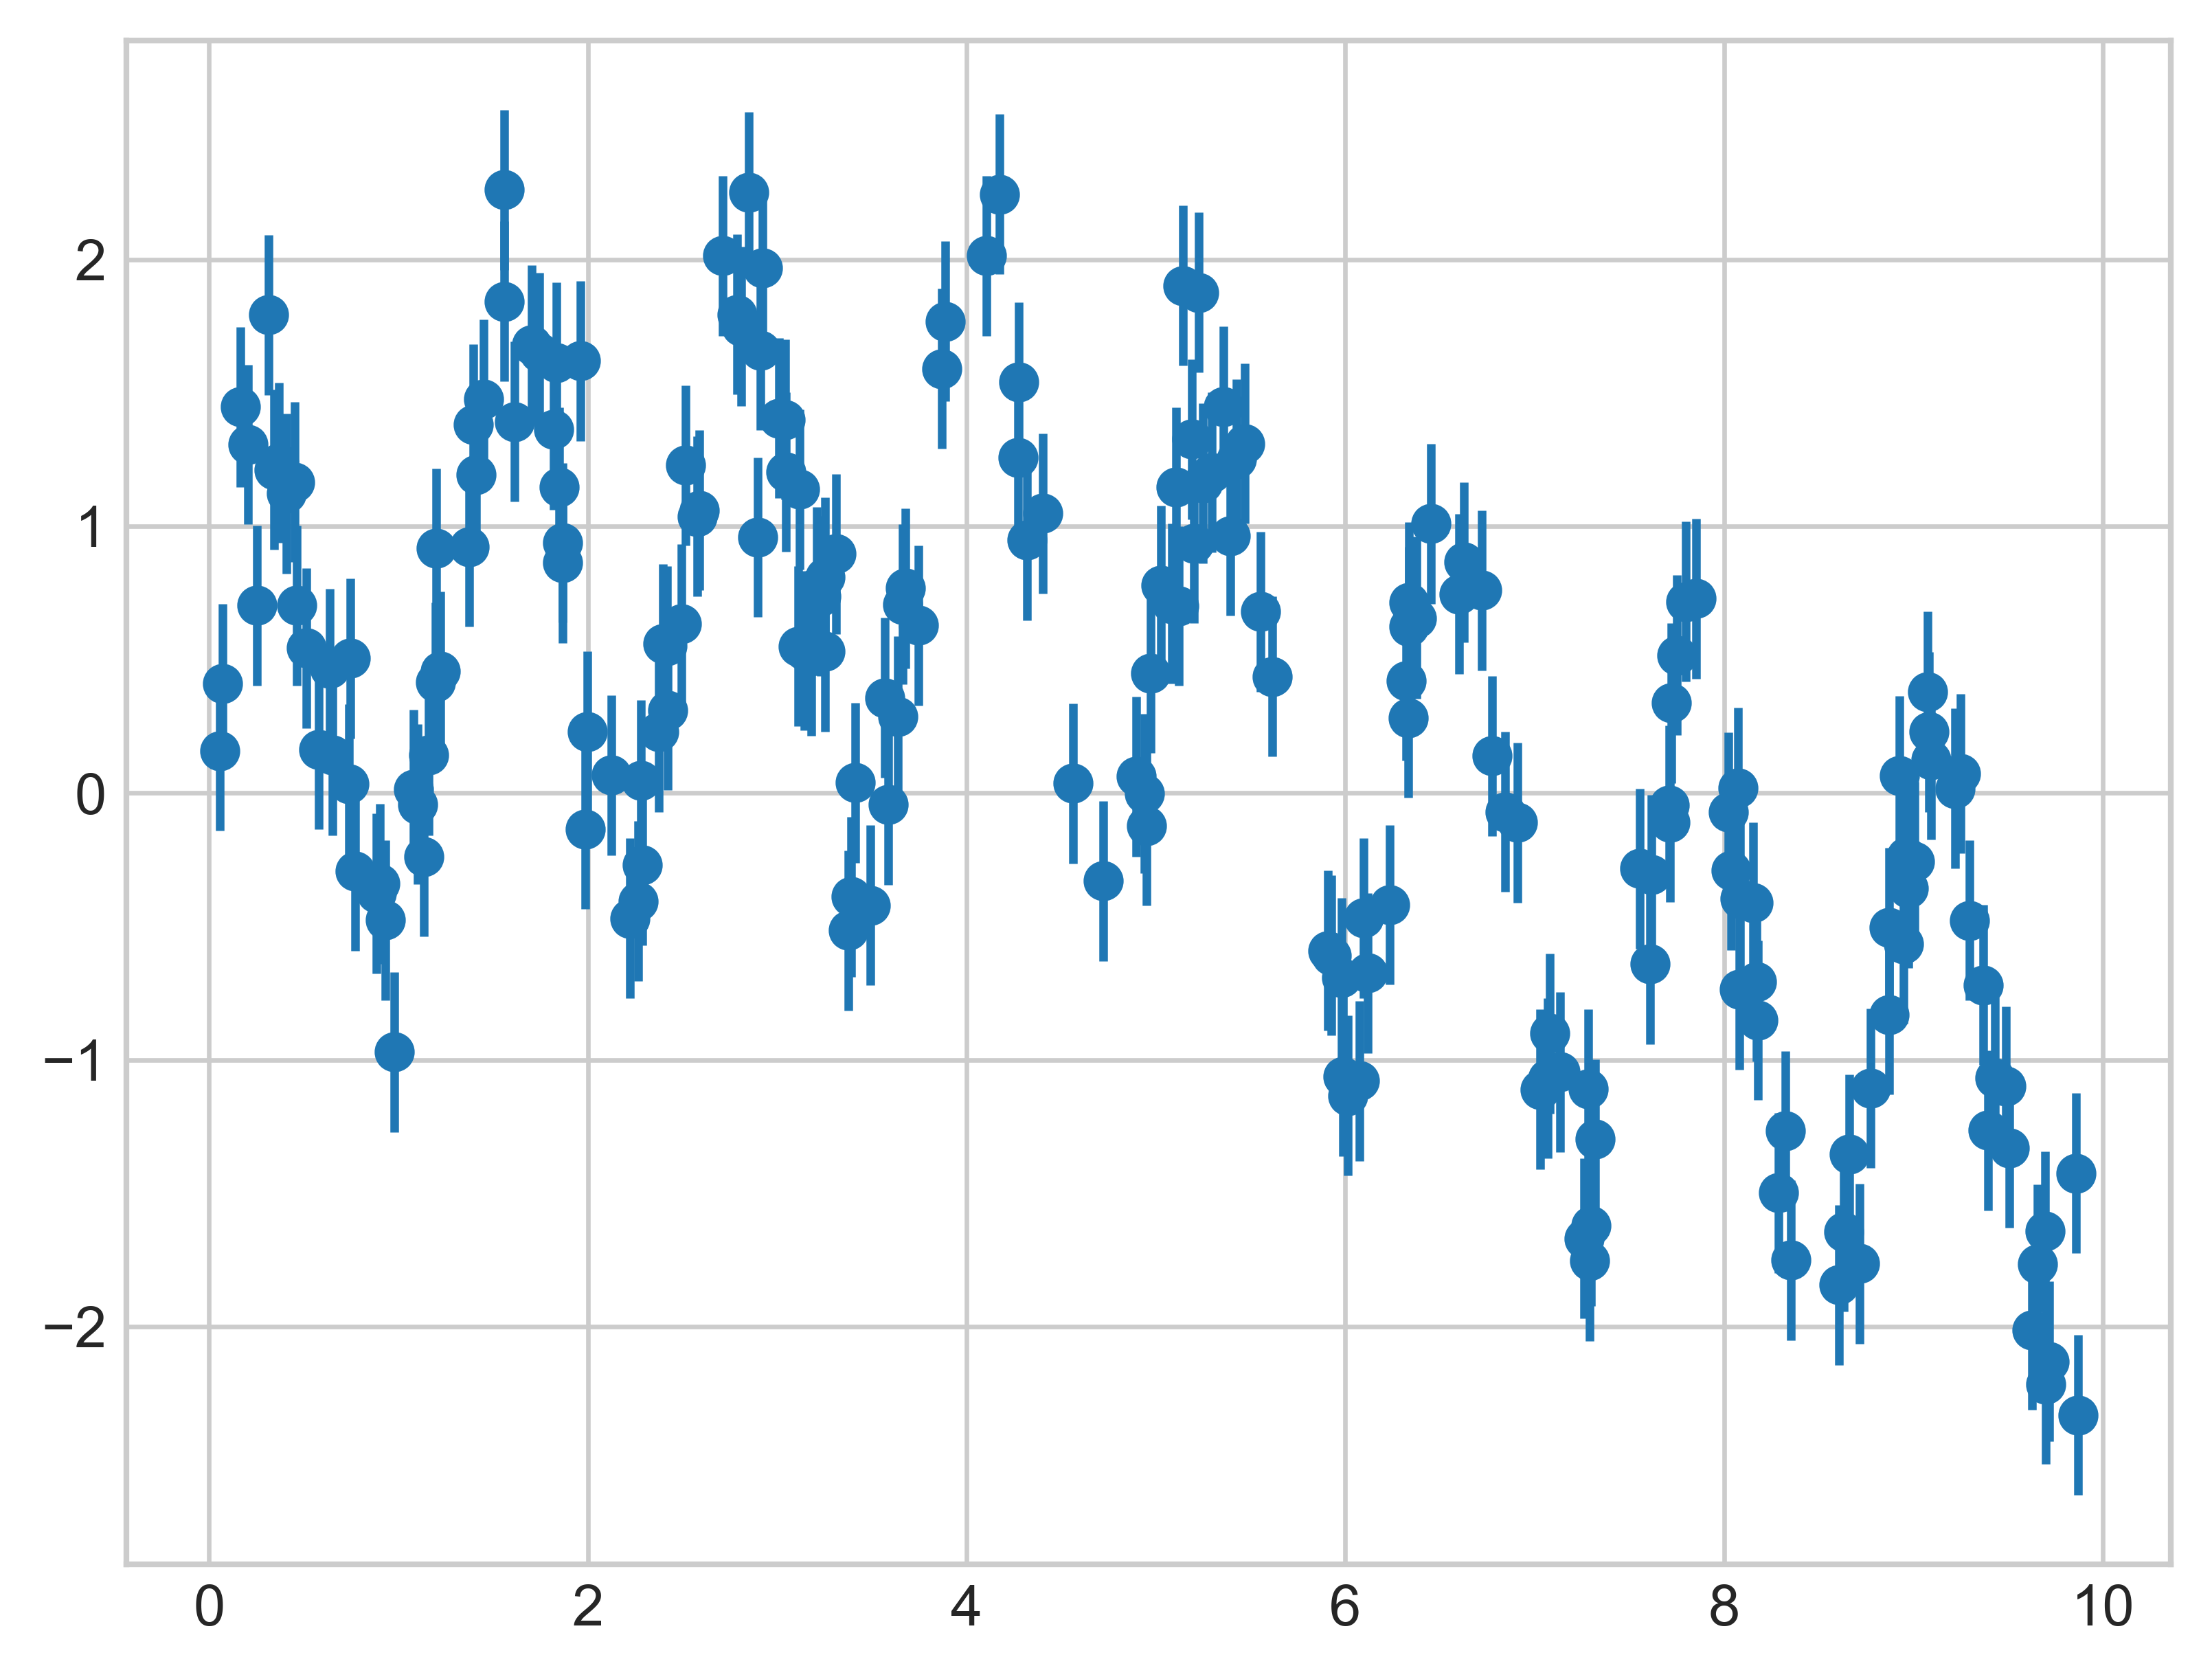

In [15]:
rng = np.random.RandomState(42)
x = 10 * rng.rand(200)

def model(x, sigma=0.3):
    fast_oscillation = np.sin(5 * x)
    slow_oscillation = np.sin(0.5 * x)
    noise = sigma * rng.randn(len(x))

    return slow_oscillation + fast_oscillation + noise

y = model(x)
plt.errorbar(x, y, 0.3, fmt='o');

Using the random forest regressor, we can find the best-fit curve as follows (see the following figure):

In [ ]:
# plotting model more efficiently

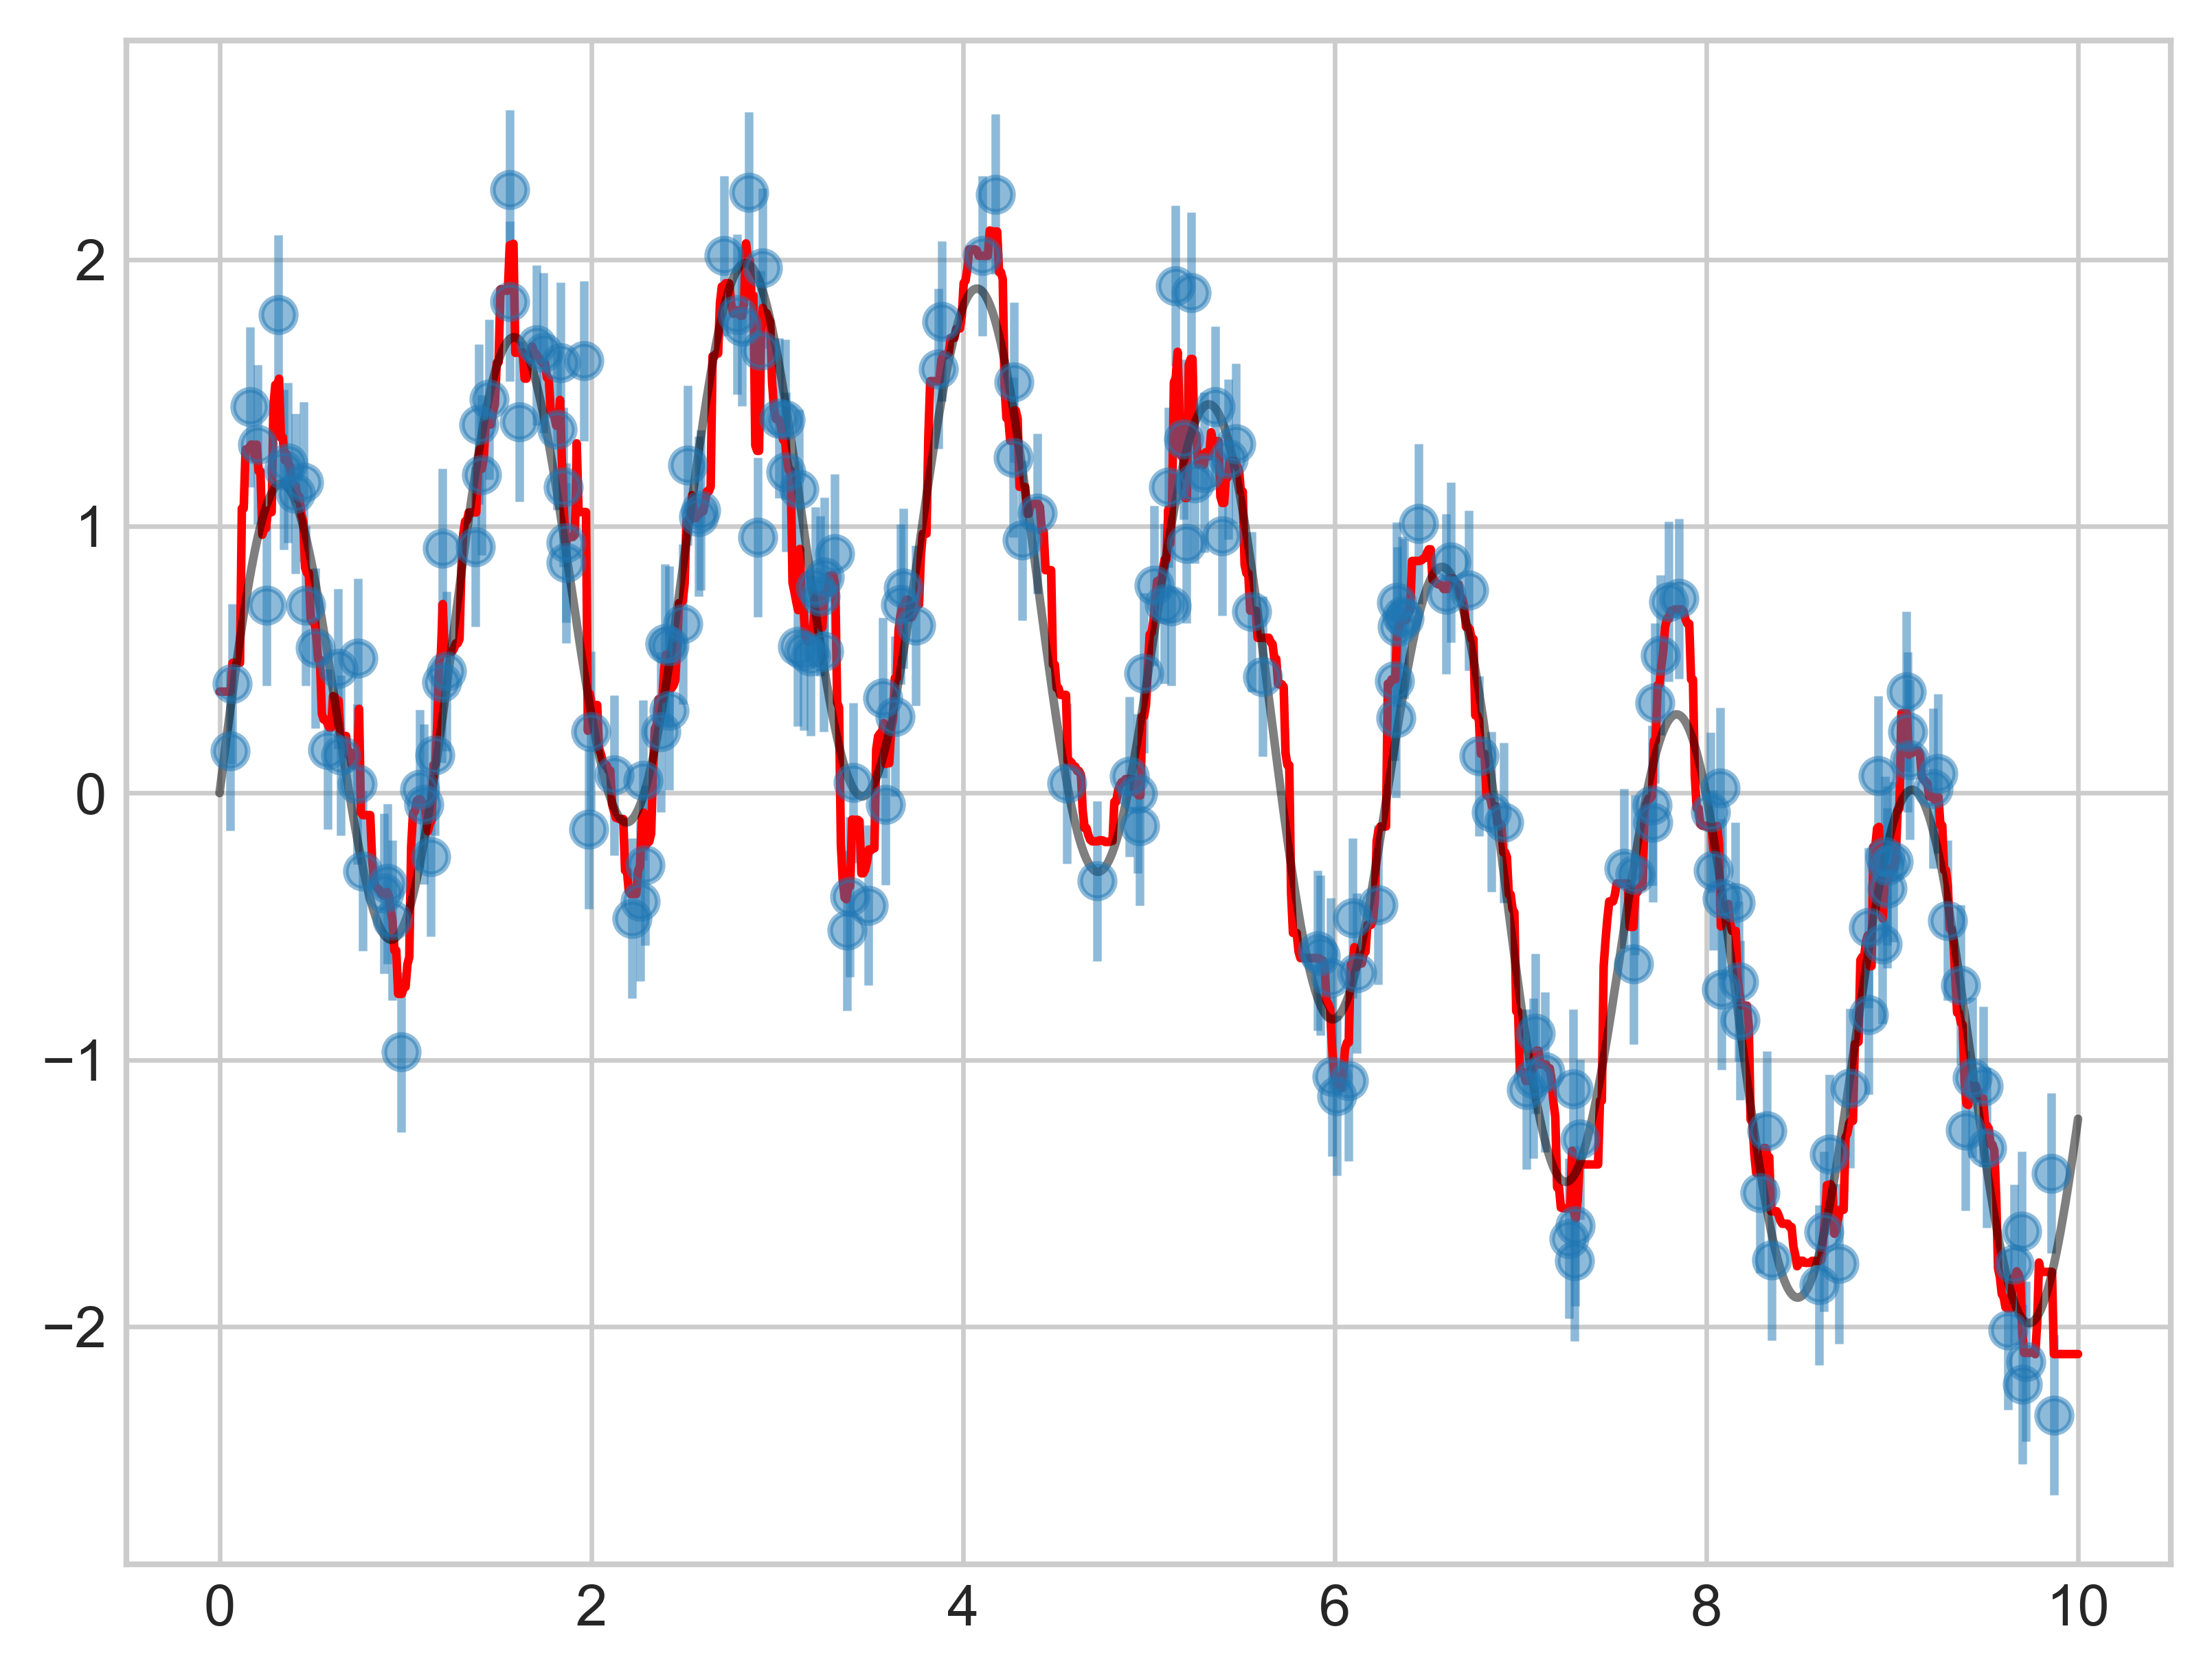

In [16]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(200)
forest.fit(x[:, None], y)

xfit = np.linspace(0, 10, 1000)
yfit = forest.predict(xfit[:, None])
ytrue = model(xfit, sigma=0)

plt.errorbar(x, y, 0.3, fmt='o', alpha=0.5)
plt.plot(xfit, yfit, '-r');
plt.plot(xfit, ytrue, '-k', alpha=0.5);

Here the true model is shown in the smooth gray curve, while the random forest model is shown by the jagged red curve.
The nonparametric random forest model is flexible enough to fit the multiperiod data, without us needing to specifying a multi-period model!

## Example: Random Forest for Classification

In [17]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np

In [18]:
# Generating Synthetic Data
X, y = make_classification(n_samples=500, n_features=2,  # 2 features for easy visualization
                           n_informative=2, n_redundant=0, n_classes=3,
                           n_clusters_per_class=1, random_state=42)

In [19]:
# Spliting Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [20]:
# Initializing and Training Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, random_state=42)

In [21]:
# Making Predictions
y_pred = clf.predict(X_test)

In [22]:
# Evaluating the Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.95

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.88      0.92        50
           1       0.93      0.98      0.96        55
           2       0.96      0.98      0.97        45

    accuracy                           0.95       150
   macro avg       0.95      0.95      0.95       150
weighted avg       0.95      0.95      0.95       150



In [23]:
# Visualizing Decision Boundaries with Heatmap
def visualize_classifier_with_heatmap(model, X, y, cmap='coolwarm'):
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, s=30, zorder=3)
    
    # Create mesh grid
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, num=200),
                         np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, num=200))
    
    # Predict probabilities for each point in the grid
    Z = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z_max_confidence = Z.max(axis=1).reshape(xx.shape)  

    # Overlay decision boundaries
    Z_class = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z_class, alpha=0.3, cmap=cmap)
    plt.imshow(Z_max_confidence, extent=(xx.min(), xx.max(), yy.min(), yy.max()), origin='lower',
               cmap='Reds', alpha=0.5, aspect='auto')

    plt.title("Decision Boundary with Confidence Heatmap")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.colorbar(label="Prediction Confidence")
    plt.show()

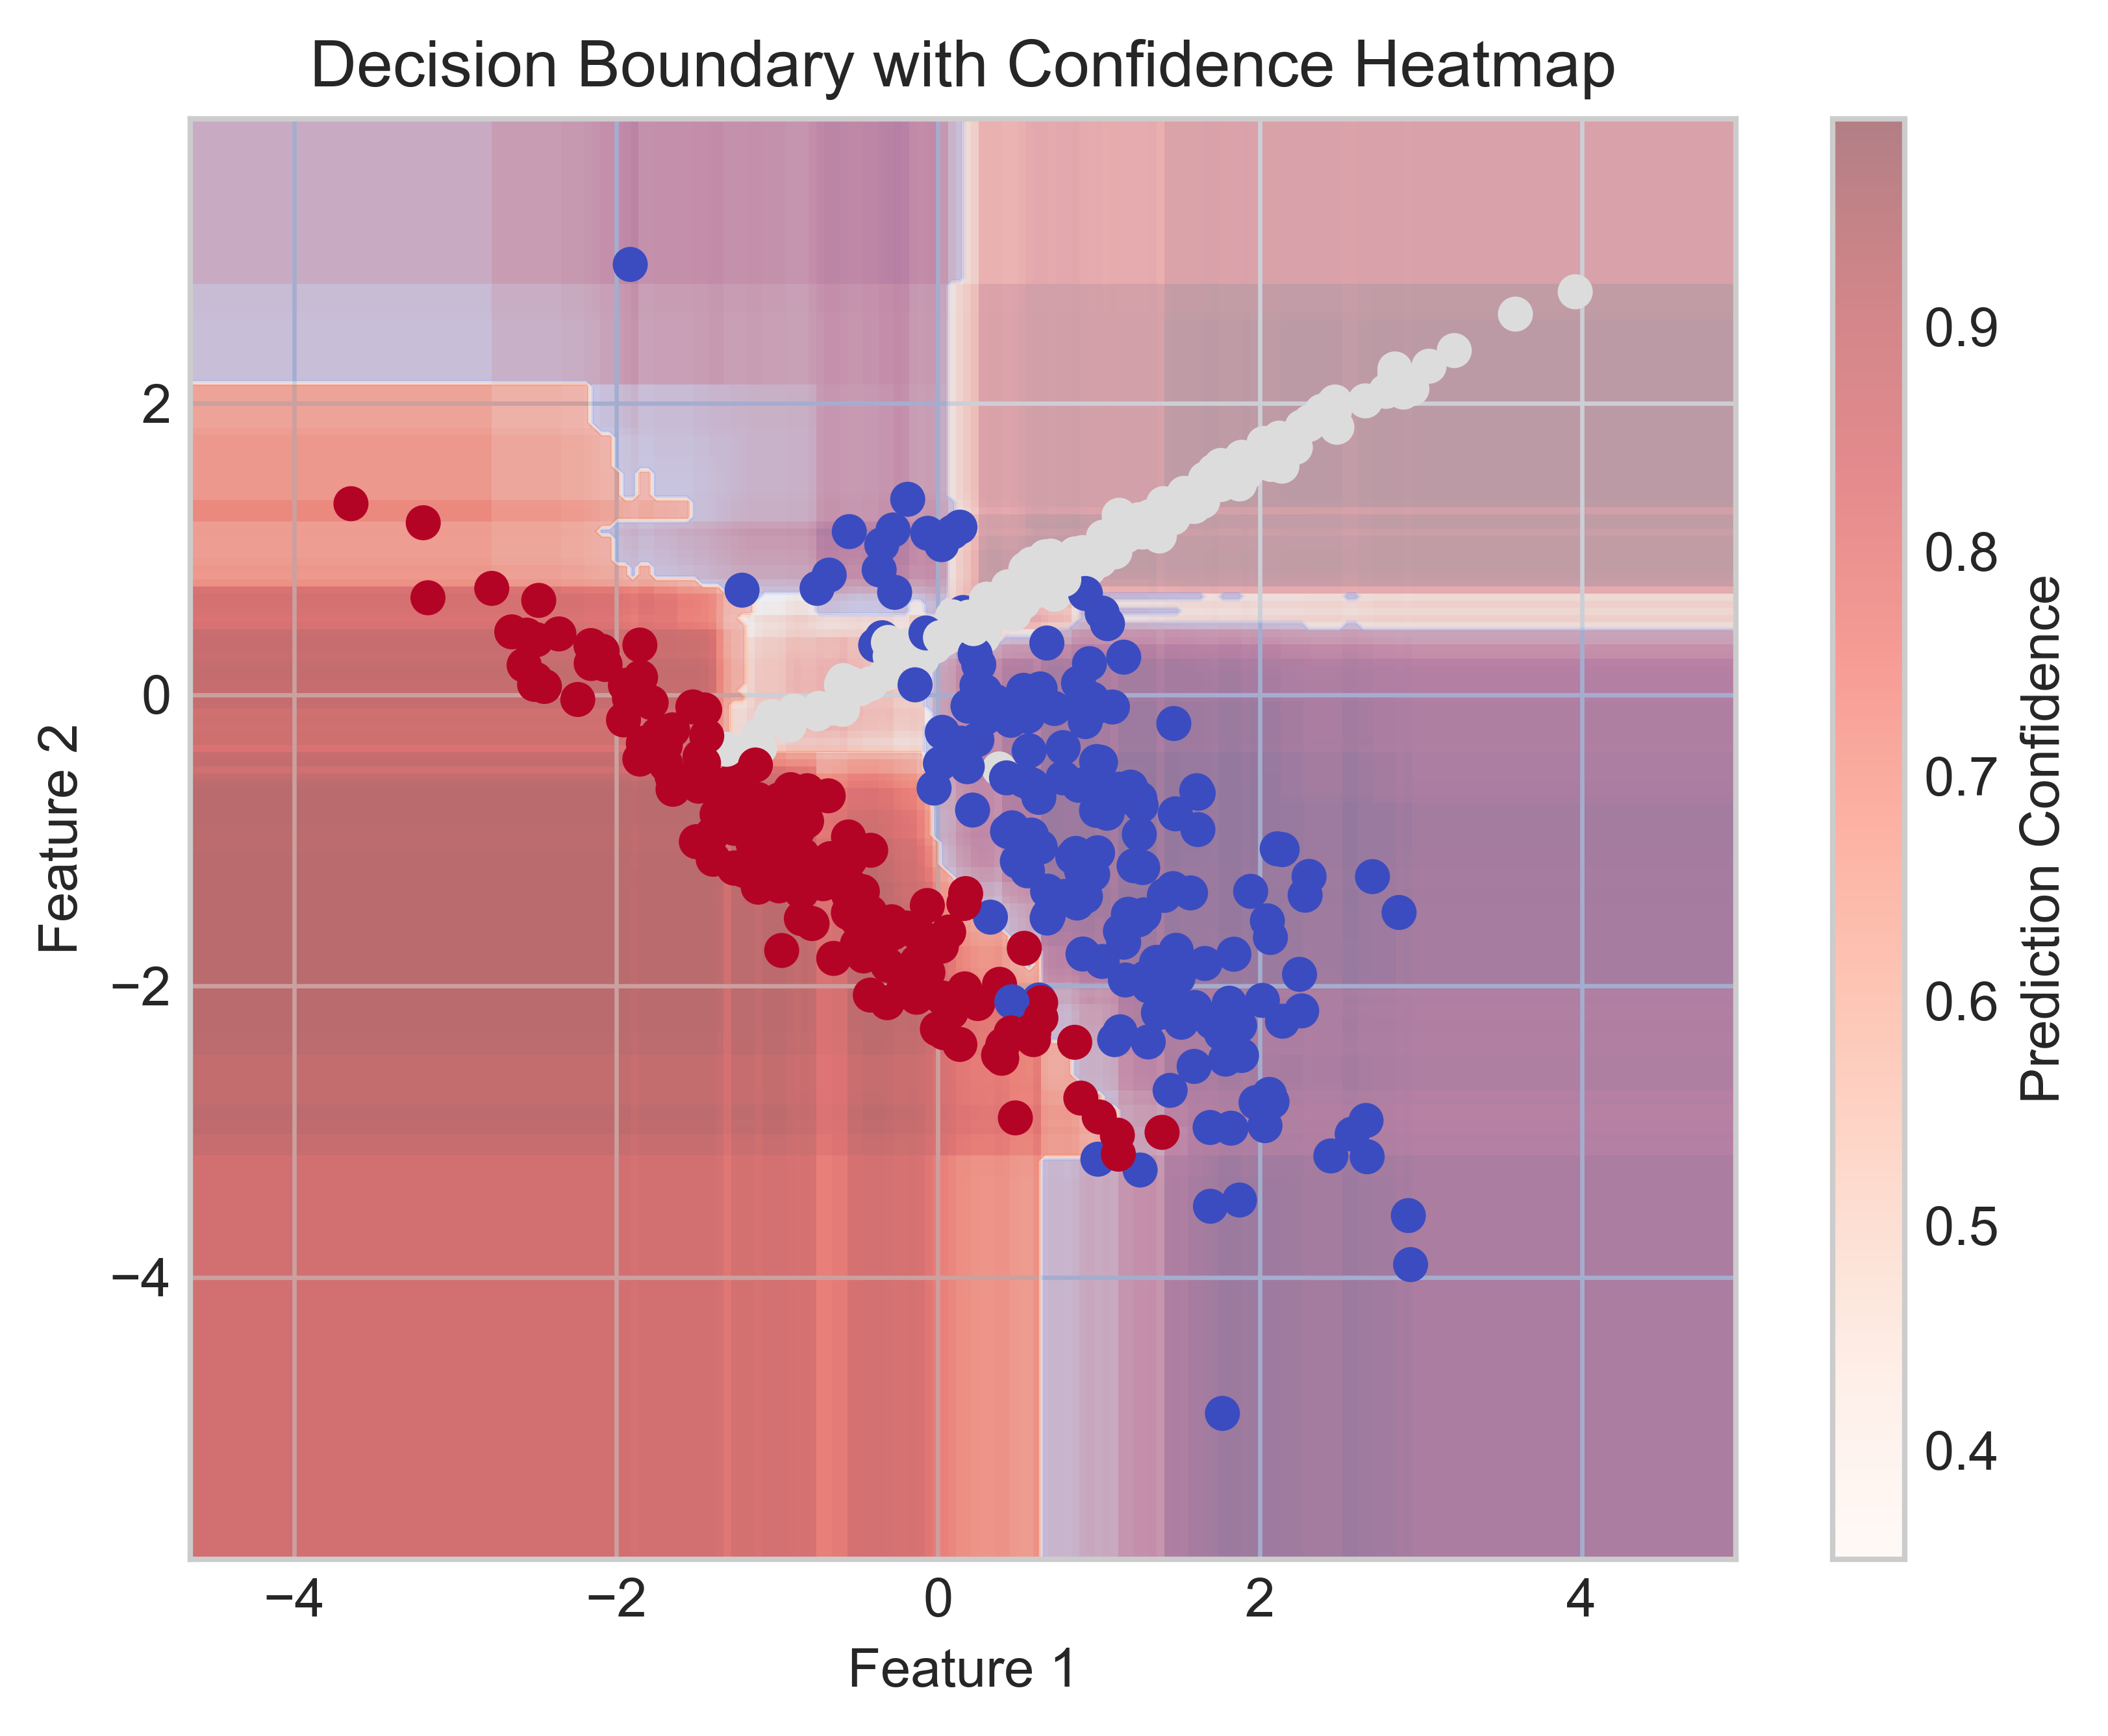

In [24]:
# Visualizing with heatmap
visualize_classifier_with_heatmap(clf, X, y)

## Summary

This chapter introduces ensemble estimators, focusing on random forests, which are ensembles of randomized decision trees. Key advantages of random forests include:

- Fast training and prediction due to the simplicity of decision trees, allowing for easy parallelization.
- Probabilistic classification through majority voting, enabling probability estimates via Scikit-Learn's `predict_proba` method.
- Flexibility as a nonparametric model, performing well on tasks that may underfit with other estimators.

However, a notable disadvantage is that random forests lack interpretability, making it difficult to draw meaningful conclusions from the classification model.
